In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [14]:

N_SPLITS = 5
RANDOM_STATE = 42
CATEGORICAL_COLS = ['property_type', 'room_type']
TARGET_COL = 'price'
MUTUAL_INFO_THRESHOLD = 1

In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_regression

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_regression

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=None):
        self.n_features = n_features
        self.selected_features_ = None
        self.mi_scores_ = None
        self._is_fitted = False

    def fit(self, X, y):
        if self._is_fitted and self.mi_scores_ is not None:
            print("MI already computed. Reusing existing ranking")
        else:
            print(f"Calculating MI for {X.shape[1]} features")
            mi_scores = mutual_info_regression(X, y, random_state=42)
            self.mi_scores_ = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
            print("Feature ranking computed and stored")
            self._is_fitted = True
        return self

    def transform(self, X):
        if self.selected_features_ is None:
            if self.n_features is not None:
                self.selected_features_ = self.mi_scores_.head(self.n_features).index.tolist()
            else:
                self.selected_features_ = self.mi_scores_[self.mi_scores_ > 0].index.tolist()
            print(f"Selecting {len(self.selected_features_)} features for transformation")
        return X[self.selected_features_]

    def set_n_features(self, n_features):
        if not self._is_fitted:
            raise ValueError("FeatureSelector not fitted yet")
        self.n_features = n_features
        if self.n_features is None:
            self.selected_features_ = self.mi_scores_[self.mi_scores_ > 0].index.tolist()
            print(f"Re-selected all {len(self.selected_features_)} features with MI score > 0.")
        else:
            self.selected_features_ = self.mi_scores_.head(self.n_features).index.tolist()
            print(f"Re-selected top {len(self.selected_features_)} features based on new n_features.")
        return self

    def get_feature_names_out(self, input_features=None):
        return np.array(self.selected_features_)



def create_preprocessing_pipeline(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    return preprocessor


def evaluate_model_cv(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    mse_scores, rmse_scores, r2_scores = [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)

        mse = mean_squared_error(y_val_fold, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_fold, y_pred)

        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f"Fold {fold+1}: MSE={mse:.2f}, RMSE={rmse:.2f}, R2={r2:.3f}")

    return {
        'avg_mse': np.mean(mse_scores),
        'mse_scores': mse_scores,
        'avg_rmse': np.mean(rmse_scores),
        'rmse_scores': rmse_scores,
        'avg_r2': np.mean(r2_scores),
        'r2_scores': r2_scores
    }


In [16]:
df_train = pd.read_csv('train_final.csv')
df_test = pd.read_csv('test_final.csv')

print(f"Original train size: {len(df_train)}")
print(f"Original test size: {len(df_test)}")

Original train size: 5464
Original test size: 1367


In [17]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

In [18]:
#df_train = df_train.sample(frac=0.01)
#df_test = df_test.sample(frac=0.01)

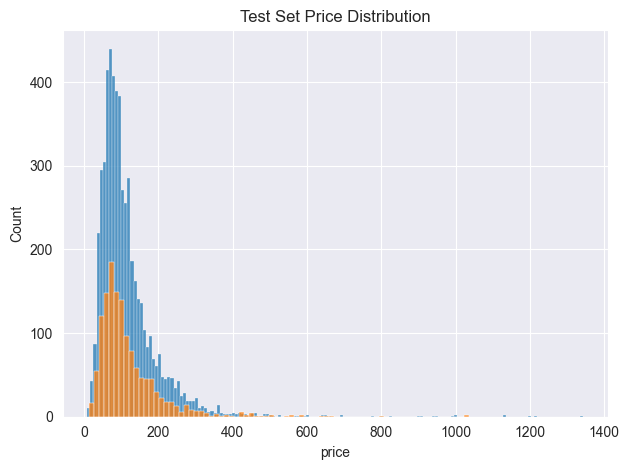

In [19]:
sns.histplot(df_train['price'], kde=False)
plt.title('Training Set Price Distribution')

sns.histplot(df_test['price'], kde=False)
plt.title('Test Set Price Distribution')
plt.tight_layout()
plt.show()

In [20]:
X_train = df_train.drop(columns=[TARGET_COL])
y_train = df_train[TARGET_COL]

X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL]

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = CATEGORICAL_COLS

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {categorical_cols}")

Numeric columns: 3549
Categorical columns: ['property_type', 'room_type']


In [21]:
# Preprocessing pipeline
preprocessor = create_preprocessing_pipeline(numeric_cols, categorical_cols)
preprocessor.fit(X_train)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [22]:
# Get feature names
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
feature_names = []
feature_names.extend(numeric_cols)
feature_names.extend(cat_encoder.get_feature_names_out(categorical_cols))

print(f"Total features after preprocessing: {len(feature_names)}")

Total features after preprocessing: 3604


In [23]:
# Transform data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Wrap as DataFrames
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print(f"Shape after preprocessing: {X_train_processed.shape}")

Shape after preprocessing: (5464, 3604)


# Optimization -> Feature Selection

In [24]:
n_features_grid = [10, 20, 30, 50, 100, 250, 500, 1000]

feature_selection_results = {}

initial_selector = FeatureSelector(n_features=None)
initial_selector.fit(X_train_processed, y_train)


for n_features in n_features_grid:
    print(f"\nTesting n_features: {n_features}")

    current_selector = initial_selector.set_n_features(n_features)

    X_train_sel = current_selector.transform(X_train_processed)
    X_test_sel = current_selector.transform(X_test_processed)

    n_features_actual = X_train_sel.shape[1]
    print(f"Features selected: {n_features_actual}")

    if n_features_actual == 0:
        print("   No features selected, skipping...")
        continue

    models = {
        'Ridge': Ridge(random_state=RANDOM_STATE),
        'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE),
        'XGBoost': XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='rmse')
    }

    feature_selection_results[n_features] = {
        'n_features': n_features_actual,
        'model_scores': {}
    }

    for model_name, model in models.items():
        try:
            cv_results = evaluate_model_cv(model, X_train_sel, y_train, n_splits=3)
            avg_mse = cv_results['avg_mse']
            avg_r2 = cv_results['avg_r2']
            feature_selection_results[n_features]['model_scores'][model_name] = {
                'mse': avg_mse,
                'r2': avg_r2
            }
            print(f" {model_name}: MSE={avg_mse:.2f}, R2={avg_r2:.3f}")
        except Exception as e:
            print(f"   RIP {model_name}: Error - {str(e)}")
            feature_selection_results[n_features]['model_scores'][model_name] = {
                'mse': np.inf,
                'r2': -np.inf
            }

Calculating MI for 3604 features
Feature ranking computed and stored

Testing n_features: 10
Re-selected top 10 features based on new n_features.
Features selected: 10
Fold 1: MSE=5016.96, RMSE=70.83, R2=0.413
Fold 2: MSE=4774.77, RMSE=69.10, R2=0.300
Fold 3: MSE=5382.97, RMSE=73.37, R2=0.313
 Ridge: MSE=5058.23, R2=0.342
Fold 1: MSE=7171.09, RMSE=84.68, R2=0.161
Fold 2: MSE=7967.12, RMSE=89.26, R2=-0.167
Fold 3: MSE=8604.71, RMSE=92.76, R2=-0.098
 DecisionTree: MSE=7914.31, R2=-0.035
Fold 1: MSE=4772.64, RMSE=69.08, R2=0.442
Fold 2: MSE=4274.58, RMSE=65.38, R2=0.374
Fold 3: MSE=4948.44, RMSE=70.35, R2=0.369
 XGBoost: MSE=4665.22, R2=0.395

Testing n_features: 20
Re-selected top 20 features based on new n_features.
Features selected: 20
Fold 1: MSE=4521.35, RMSE=67.24, R2=0.471
Fold 2: MSE=4327.39, RMSE=65.78, R2=0.366
Fold 3: MSE=5476.23, RMSE=74.00, R2=0.301
 Ridge: MSE=4774.99, R2=0.379
Fold 1: MSE=6637.41, RMSE=81.47, R2=0.224
Fold 2: MSE=6807.05, RMSE=82.50, R2=0.003
Fold 3: MSE=8

In [25]:
summary_data = []
for n_features, results in feature_selection_results.items():
    for model_name, scores in results['model_scores'].items():
        mse = scores['mse']
        rmse = np.sqrt(mse) if np.isfinite(mse) else np.inf
        summary_data.append({
            'N_Features': n_features,
            'Model': model_name,
            'MSE': mse,
            'RMSE': rmse,
            'R2': scores['r2']
        })
summary_df = pd.DataFrame(summary_data)

In [26]:
print("\nBest n_features by model:")
for model in summary_df['Model'].unique():
    model_data = summary_df[summary_df['Model'] == model]
    best_idx = model_data['MSE'].idxmin()
    best_row = model_data.loc[best_idx]
    print(f"   {model}: n_features={best_row['N_Features']}, MSE={best_row['MSE']:.2f}, RMSE={best_row['RMSE']:.2f}, R2={best_row['R2']:.3f}")


Best n_features by model:
   Ridge: n_features=100, MSE=4099.23, RMSE=64.03, R2=0.468
   DecisionTree: n_features=50, MSE=6649.99, RMSE=81.55, R2=0.126
   XGBoost: n_features=50, MSE=3620.43, RMSE=60.17, R2=0.528


In [27]:
optimal_feature_sets = {}
for model_name in summary_df['Model'].unique():
    model_data = summary_df[summary_df['Model'] == model_name]
    best_idx = model_data['MSE'].idxmin()
    best_row = model_data.loc[best_idx]


    initial_selector.n_features = best_row['N_Features']

    X_train_model = initial_selector.transform(X_train_processed)
    X_test_model = initial_selector.transform(X_test_processed)

    optimal_feature_sets[model_name] = {
        'n_features': best_row['N_Features'],
        'X_train': X_train_model,
        'X_test': X_test_model,
        'selector': initial_selector
    }

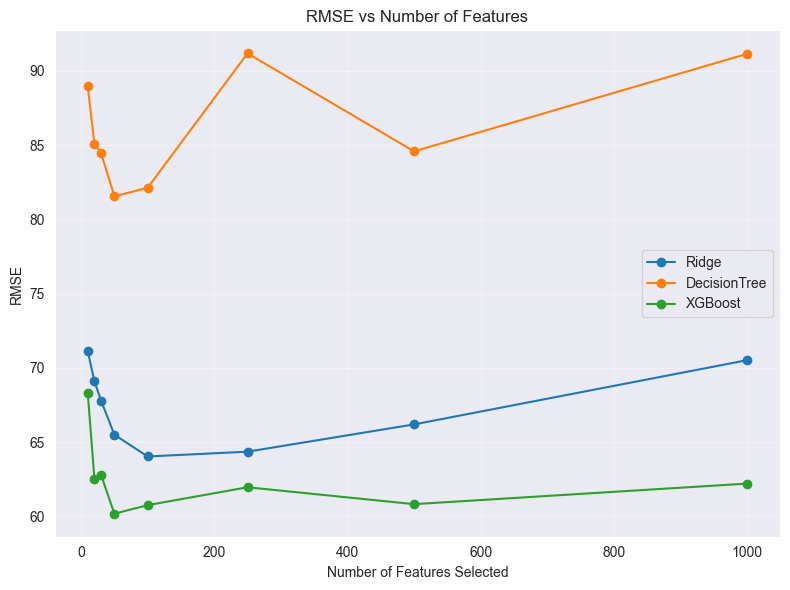

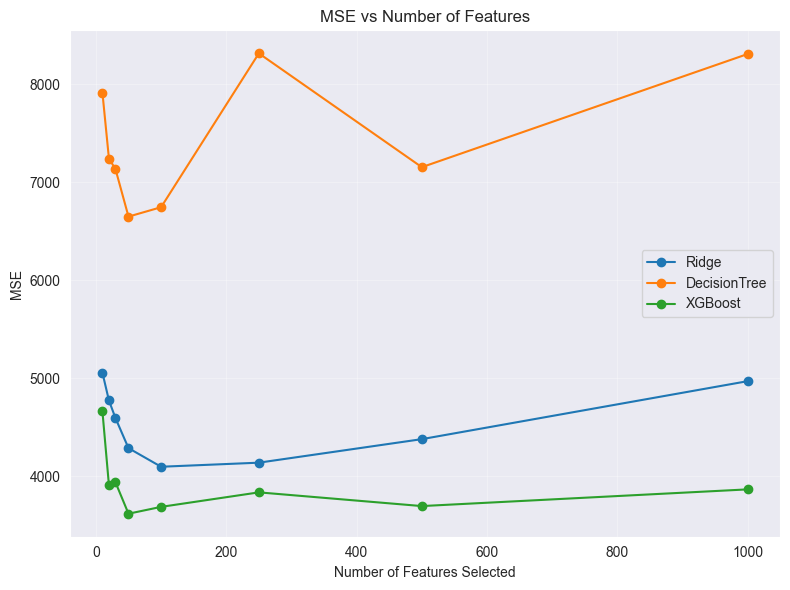

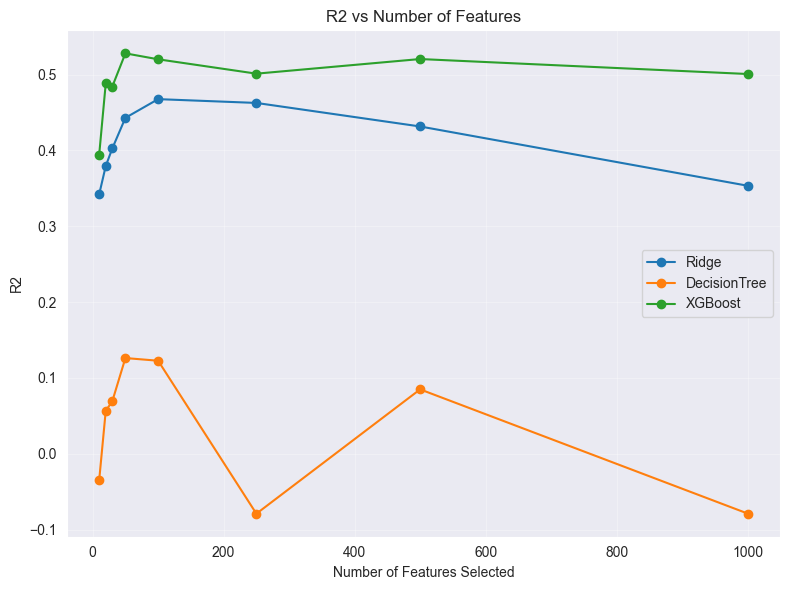

In [29]:
# Plot 1: RMSE vs N_Features
plt.figure(figsize=(8, 6))
for model_name in summary_df['Model'].unique():
    model_data = summary_df[summary_df['Model'] == model_name].sort_values(by='N_Features')
    plt.plot(model_data['N_Features'], model_data['RMSE'], 'o-', label=model_name)
plt.xlabel('Number of Features Selected')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: MSE vs N_Features
plt.figure(figsize=(8, 6))
for model_name in summary_df['Model'].unique():
    model_data = summary_df[summary_df['Model'] == model_name].sort_values(by='N_Features')
    plt.plot(model_data['N_Features'], model_data['MSE'], 'o-', label=model_name)
plt.xlabel('Number of Features Selected')
plt.ylabel('MSE')
plt.title('MSE vs Number of Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: R2 vs N_Features
plt.figure(figsize=(8, 6))
for model_name in summary_df['Model'].unique():
    model_data = summary_df[summary_df['Model'] == model_name].sort_values(by='N_Features')
    plt.plot(model_data['N_Features'], model_data['R2'], 'o-', label=model_name)
plt.xlabel('Number of Features Selected')
plt.ylabel('R2')
plt.title('R2 vs Number of Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Hyperparameter Optimization


In [30]:
cv_splitter = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

best_models = {}

In [31]:
# 1. Ridge Regression with GridSearchCV

ridge_features = optimal_feature_sets['Ridge']
print(f" {ridge_features['n_features']} features")

ridge_grid = GridSearchCV(
    Ridge(random_state=RANDOM_STATE),
    param_grid={'alpha': np.logspace(-2, 4, 30)},
    cv=cv_splitter,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
ridge_grid.fit(ridge_features['X_train'], y_train)

best_mse = -ridge_grid.best_score_
best_rmse = np.sqrt(best_mse)
print(f"Best Ridge CV MSE: {best_mse:.2f}")

best_models['Ridge'] = {
    'model': ridge_grid.best_estimator_,
    'params': ridge_grid.best_params_,
    'cv_mse': best_mse,
    'cv_rmse': best_rmse,
    'features': ridge_features
}

 100 features
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Ridge CV MSE: 4194.83


In [32]:
# 2. Decision Tree with Bayesian Optimization
dt_features = optimal_feature_sets['DecisionTree']
print(f"Using {dt_features['n_features']} features")

dt_param_space = {
    'max_depth': Integer(3, 12),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf': Integer(1, 8),
    'max_features': Categorical(['sqrt', 'log2', None]),
    'ccp_alpha': Real(0.0, 0.05),
}


dt_bayes = BayesSearchCV(
    estimator=DecisionTreeRegressor(random_state=RANDOM_STATE),
    search_spaces=dt_param_space,
    n_iter=100,
    cv=cv_splitter,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
dt_bayes.fit(dt_features['X_train'], y_train)

best_mse = -dt_bayes.best_score_
best_rmse = np.sqrt(best_mse)
print(f"Best Decision Tree CV MSE: {best_mse:.2f}")

best_models['DecisionTree'] = {
    'model': dt_bayes.best_estimator_,
    'params': dt_bayes.best_params_,
    'cv_mse': best_mse,
    'cv_rmse': best_rmse,
    'features': dt_features
}

Using 50 features
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/dawid/Desktop/aribnb/.venv_tfidf/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.05, np.int64(3), None, np.int64(8), np.int64(15)] before, using random point [0.002442252767263637, np.int64(10), 'log2', np.int64(6), np.int64(9)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [33]:
# 3. XGBoost with Bayesian Optimization

# 1st run
'''
xgb_param_space = {
    'n_estimators': Integer(100, 1000),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'gamma': Real(0, 10),
    'reg_alpha': Real(0, 10),
    'reg_lambda': Real(0, 10),
    'min_child_weight': Integer(1, 20)
}
'''
xgb_features = optimal_feature_sets['XGBoost']

# 2nd try - more conservative - prevent overfitting
xgb_param_space = {
    'n_estimators': Integer(100, 400),
    'learning_rate': Real(0.005, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 5),
    'subsample': Real(0.6, 0.8),
    'colsample_bytree': Real(0.6, 0.8),
    'gamma': Real(1, 15),
    'reg_alpha': Real(0.4, 20),
    'reg_lambda': Real(2, 20),
    'min_child_weight': Integer(8, 40)
}

xgb_bayes = BayesSearchCV(
    estimator=XGBRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='rmse',
        tree_method='hist',
        objective='reg:squarederror'
    ),
    search_spaces=xgb_param_space,
    n_iter=100,
    cv=cv_splitter,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

xgb_bayes.fit(xgb_features['X_train'], y_train)

best_mse = -xgb_bayes.best_score_
best_rmse = np.sqrt(best_mse)
print(f"Best XGBoost CV MSE: {best_mse:.2f}")

best_models['XGBoost'] = {
    'model': xgb_bayes.best_estimator_,
    'params': xgb_bayes.best_params_,
    'cv_mse': best_mse,
    'cv_rmse': best_rmse,
    'features': xgb_features
}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [34]:
# Summary of optimization results
optimization_summary = []
for model_name, results in best_models.items():
    optimization_summary.append({
        'Model': model_name,
        'CV_RMSE': results['cv_rmse'],
        'CV_MSE': results['cv_mse'],
        'Features': results['features']['n_features'],
    })

opt_summary_df = pd.DataFrame(optimization_summary)
print(opt_summary_df.to_string(index=False))

       Model   CV_RMSE      CV_MSE  Features
       Ridge 64.767479 4194.826358       100
DecisionTree 73.692022 5430.514129        50
     XGBoost 56.706942 3215.677262        50


In [35]:
# Find the best overall model
best_overall_model = min(best_models.keys(), key=lambda x: best_models[x]['cv_mse'])
print(f"\n Best overall model: {best_overall_model}")
print(f" CV MSE: {best_models[best_overall_model]['cv_mse']:.2f}")


 Best overall model: XGBoost
 CV MSE: 3215.68


In [36]:
# Final Evaluation

def evaluate_model_with_features(model, X_train_features, X_test_features, y_train, y_test):
    train_preds = model.predict(X_train_features)
    test_preds = model.predict(X_test_features)

    results = {
        'train': {
            'preds': train_preds,
            'mse': mean_squared_error(y_train, train_preds),
            'rmse': np.sqrt(mean_squared_error(y_train, train_preds)),
            'r2': r2_score(y_train, train_preds)
        },
        'test': {
            'preds': test_preds,
            'mse': mean_squared_error(y_test, test_preds),
            'rmse': np.sqrt(mean_squared_error(y_test, test_preds)),
            'r2': r2_score(y_test, test_preds)
        }
    }
    return results

In [37]:
# Evaluate all final models
final_results = {}
for model_name, model_info in best_models.items():
    model = model_info['model']
    features = model_info['features']

    results = evaluate_model_with_features(
        model,
        features['X_train'],
        features['X_test'],
        y_train,
        y_test
    )

    final_results[model_name] = results

In [38]:
# Create comprehensive comparison table
comparison_data = []
for model_name, results in final_results.items():
    comparison_data.append({
        'Model': model_name,
        'Features': best_models[model_name]['features']['n_features'],
        'Train_RMSE': results['train']['rmse'],
        'Train_R2': results['train']['r2'],
        'Test_RMSE': results['test']['rmse'],
        'Test_R2': results['test']['r2'],
        'Overfitting': results['train']['rmse'] - results['test']['rmse']
    })

comparison_df = pd.DataFrame(comparison_data)
print("Comparison")
print(comparison_df.round(4).to_string(index=False))

Comparison
       Model  Features  Train_RMSE  Train_R2  Test_RMSE  Test_R2  Overfitting
       Ridge       100     57.1345    0.5783    65.4067   0.4940      -8.2722
DecisionTree        50     67.7629    0.4069    70.6088   0.4103      -2.8459
     XGBoost        50     27.4051    0.9030    54.4419   0.6495     -27.0368


In [39]:
# Find best test performance
best_test_model = comparison_df.loc[comparison_df['Test_RMSE'].idxmin()]
print(f"\n best test performance: {best_test_model['Model']}")
print(f" Test RMSE: {best_test_model['Test_RMSE']:.2f}")
print(f"  Test R²: {best_test_model['Test_R2']:.4f}")


 best test performance: XGBoost
 Test RMSE: 54.44
  Test R²: 0.6495


In [44]:
def plot_model_comparison(final_results, y_train, y_test):
    n_models = len(final_results)
    fig, axes = plt.subplots(2, n_models, figsize=(6 * n_models, 12))

    if n_models == 1:
        axes = axes.reshape(2, 1)

    for i, (model_name, results) in enumerate(final_results.items()):
        # Training set plot
        ax_train = axes[0, i]
        train_preds = results['train']['preds']
        ax_train.scatter(y_train, train_preds, alpha=0.6, color='blue')
        ax_train.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
        ax_train.set_xlabel('True Values')
        ax_train.set_ylabel('Predictions')
        ax_train.set_title(
            f'{model_name} - Training Set\nRMSE: {results["train"]["rmse"]:.2f}, R2: {results["train"]["r2"]:.3f}')
        ax_train.grid(True, alpha=0.3)

        # Test set plot
        ax_test = axes[1, i]
        test_preds = results['test']['preds']
        ax_test.scatter(y_test, test_preds, alpha=0.6, color='green')
        ax_test.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax_test.set_xlabel('True Values')
        ax_test.set_ylabel('Predictions')
        ax_test.set_title(
            f'{model_name} - Test Set\nRMSE: {results["test"]["rmse"]:.2f}, R2: {results["test"]["r2"]:.3f}')
        ax_test.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

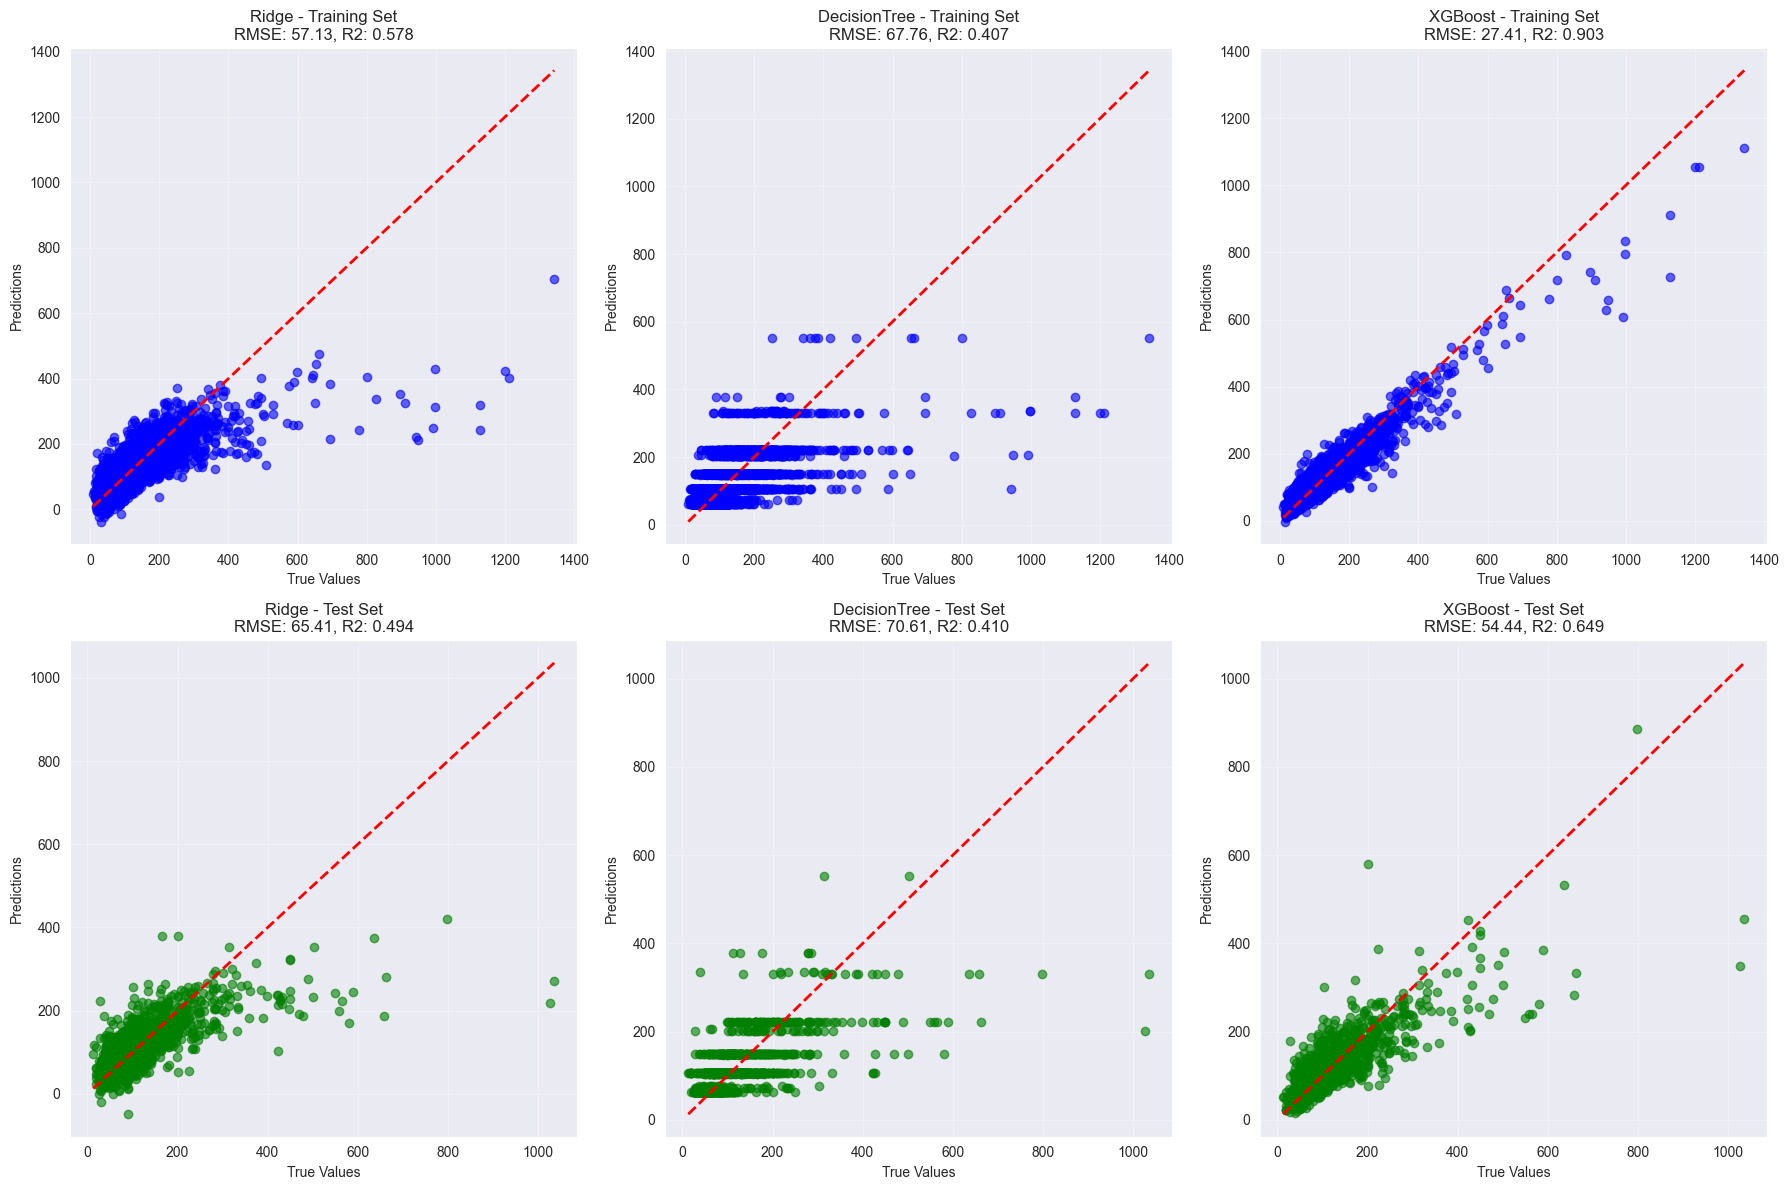

In [45]:
# Plot results
plot_model_comparison(final_results, y_train, y_test)

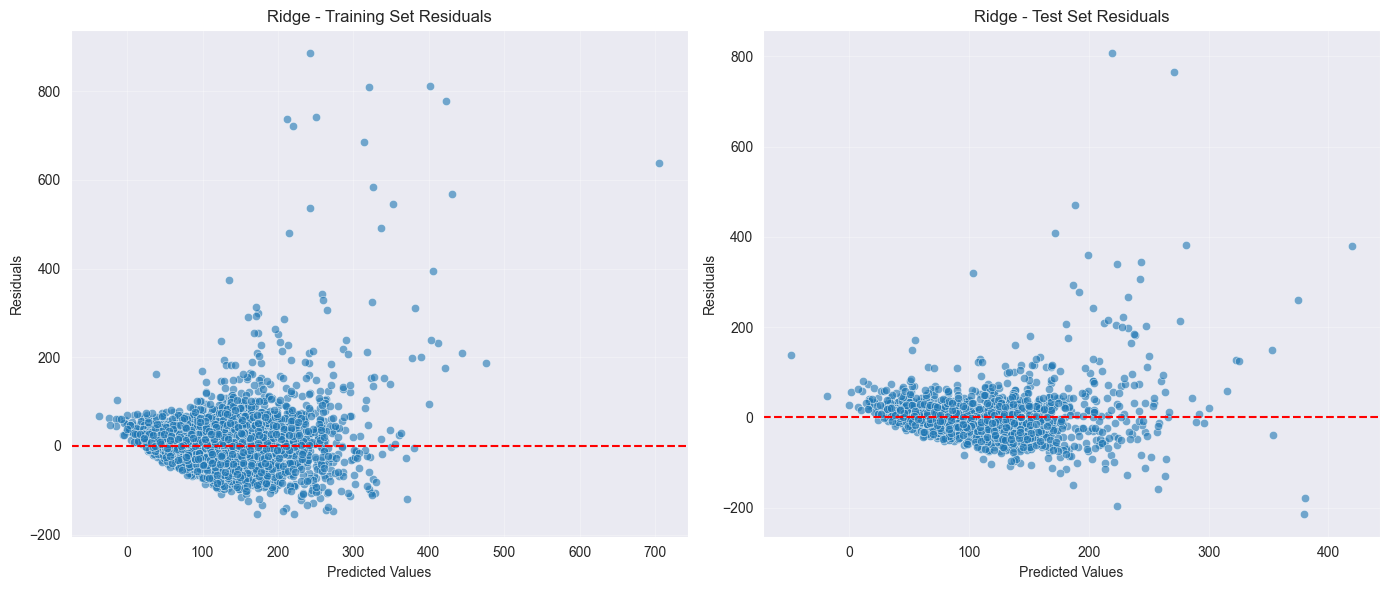

/var/folders/xp/n773dp7x3nvgjwyzq1nwyjg00000gn/T/ipykernel_62866/3703254055.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='viridis')


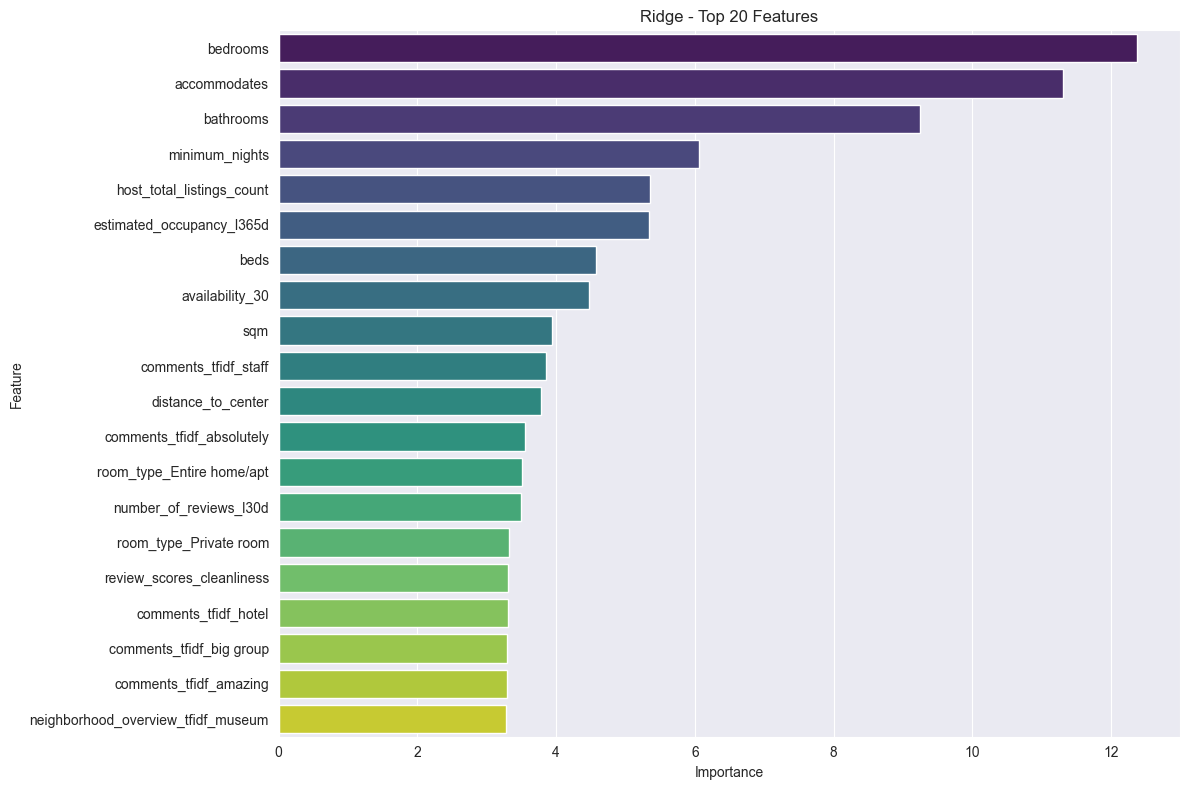

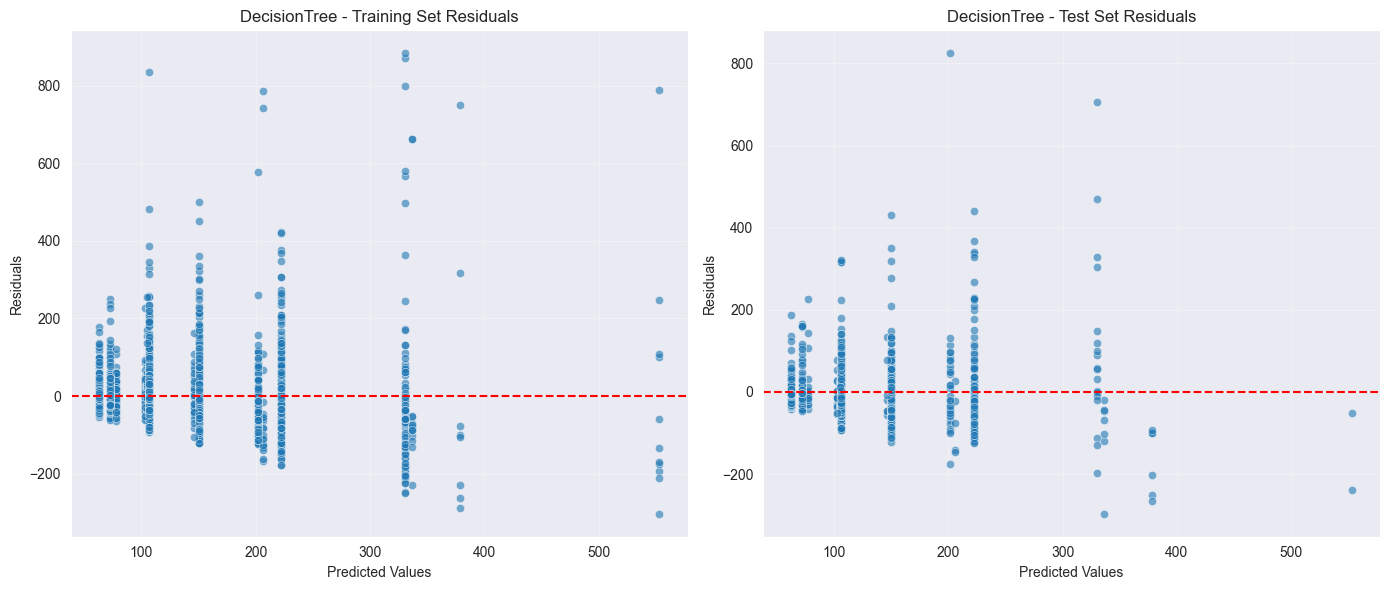

/var/folders/xp/n773dp7x3nvgjwyzq1nwyjg00000gn/T/ipykernel_62866/3703254055.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='viridis')


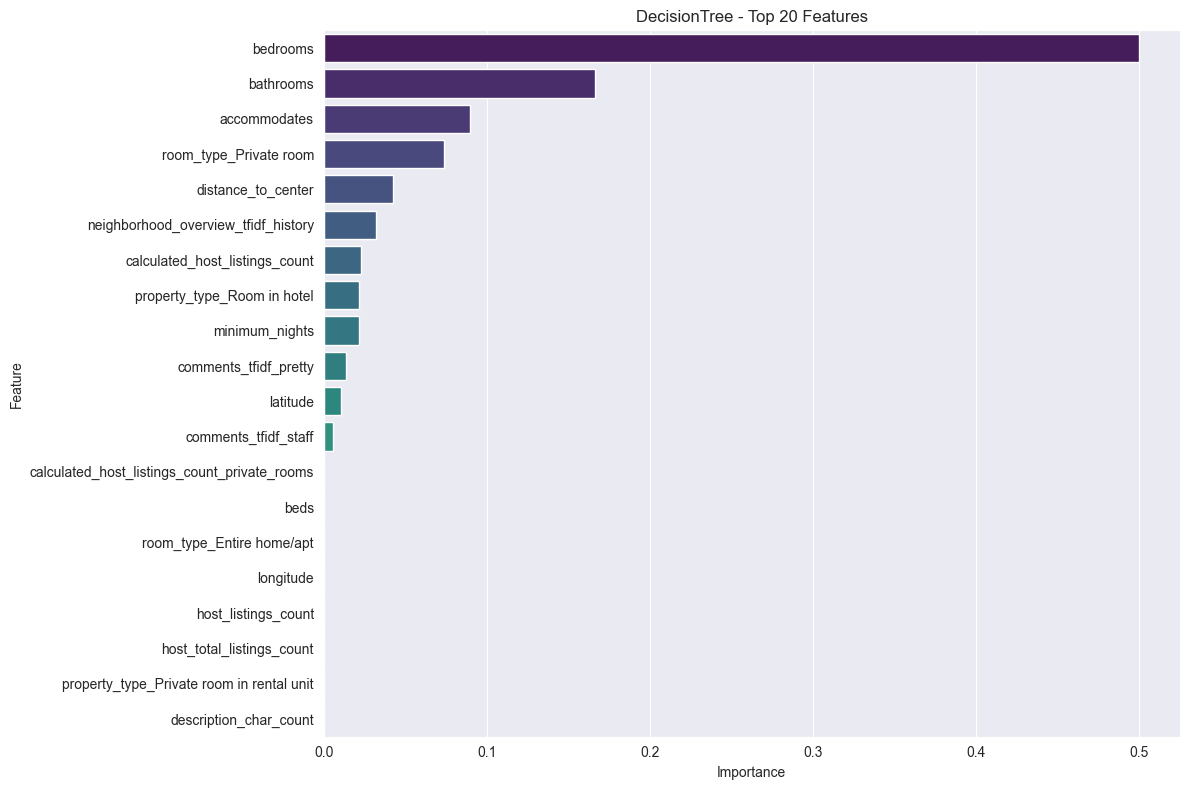

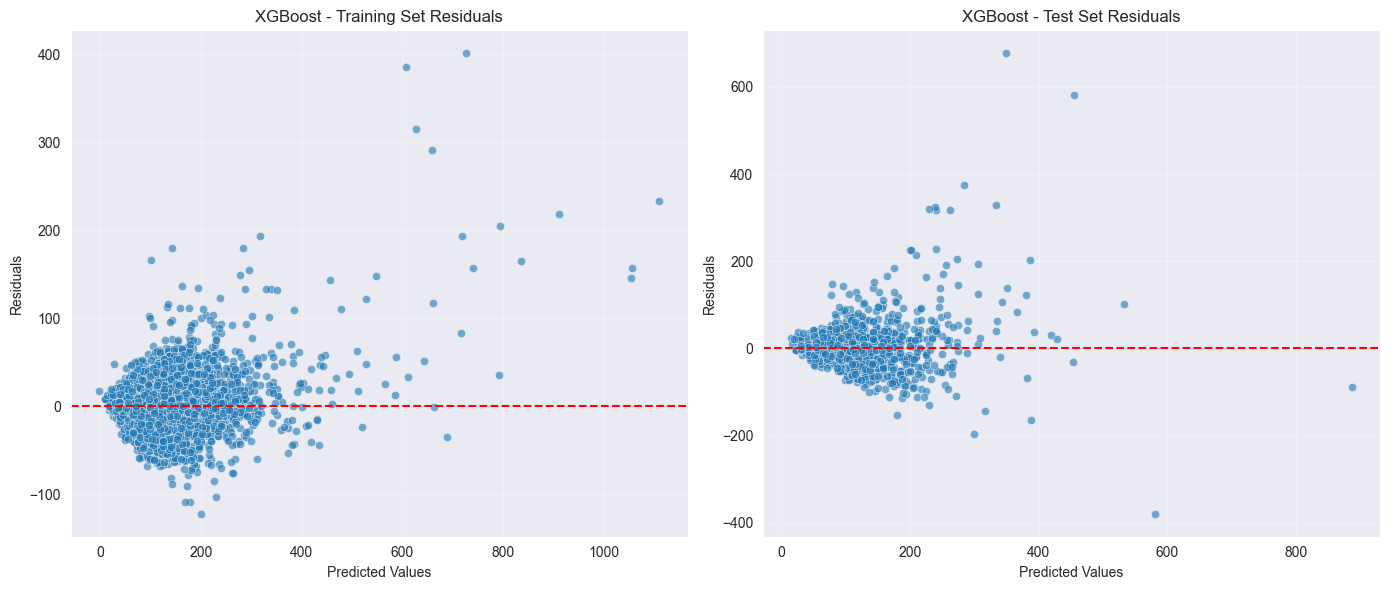

/var/folders/xp/n773dp7x3nvgjwyzq1nwyjg00000gn/T/ipykernel_62866/3703254055.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='viridis')


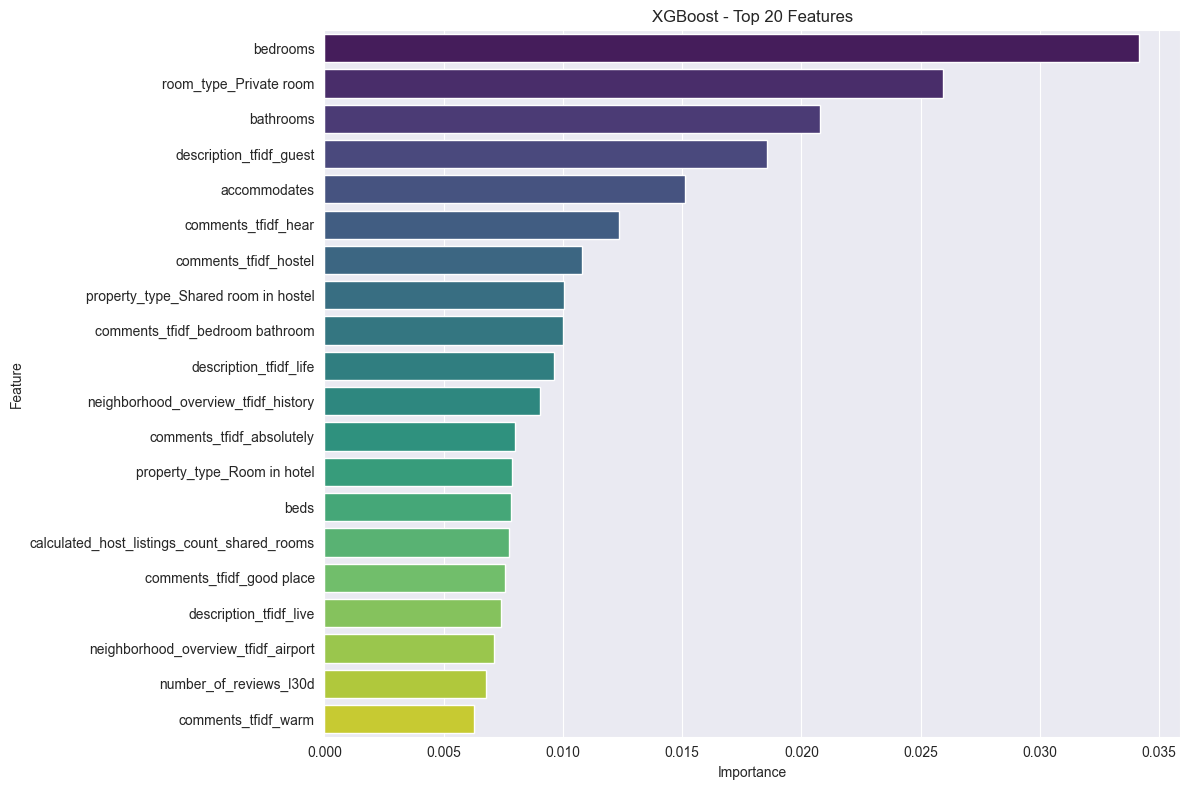

In [46]:
# Residual Plots & Top 20 Features Plots
for model_name, model_info in best_models.items():
    model = model_info['model']
    features_data = model_info['features']
    X_train_sel = features_data['X_train']
    X_test_sel = features_data['X_test']

    y_train_pred = model.predict(X_train_sel)
    y_test_pred = model.predict(X_test_sel)

    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_train_pred, y=train_residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Training Set Residuals')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test_pred, y=test_residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Test Set Residuals')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Plotting Top 20 Features
    feature_importances = None
    feature_names = X_train_sel.columns

    if hasattr(model, 'feature_importances_'):
        feature_importances = pd.Series(model.feature_importances_, index=feature_names)
    elif hasattr(model, 'coef_'):
        feature_importances = pd.Series(np.abs(model.coef_), index=feature_names)

    if feature_importances is not None:
        top_20_features = feature_importances.nlargest(20)

        if not top_20_features.empty:
            plt.figure(figsize=(12, 8))
            sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='viridis')
            plt.title(f'{model_name} - Top 20 Features')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()





 Model Comparison (by Test RMSE):
       Model  Features  Train_RMSE  Test_RMSE  Train_R2  Test_R2  Train_ExplainedVar  Test_ExplainedVar  Overfitting_Gap
     XGBoost        50     27.4051    54.4419    0.9030   0.6495              0.9030             0.6499         -27.0368
       Ridge       100     57.1345    65.4067    0.5783   0.4940              0.5783             0.4955          -8.2722
DecisionTree        50     67.7629    70.6088    0.4069   0.4103              0.4069             0.4112          -2.8459


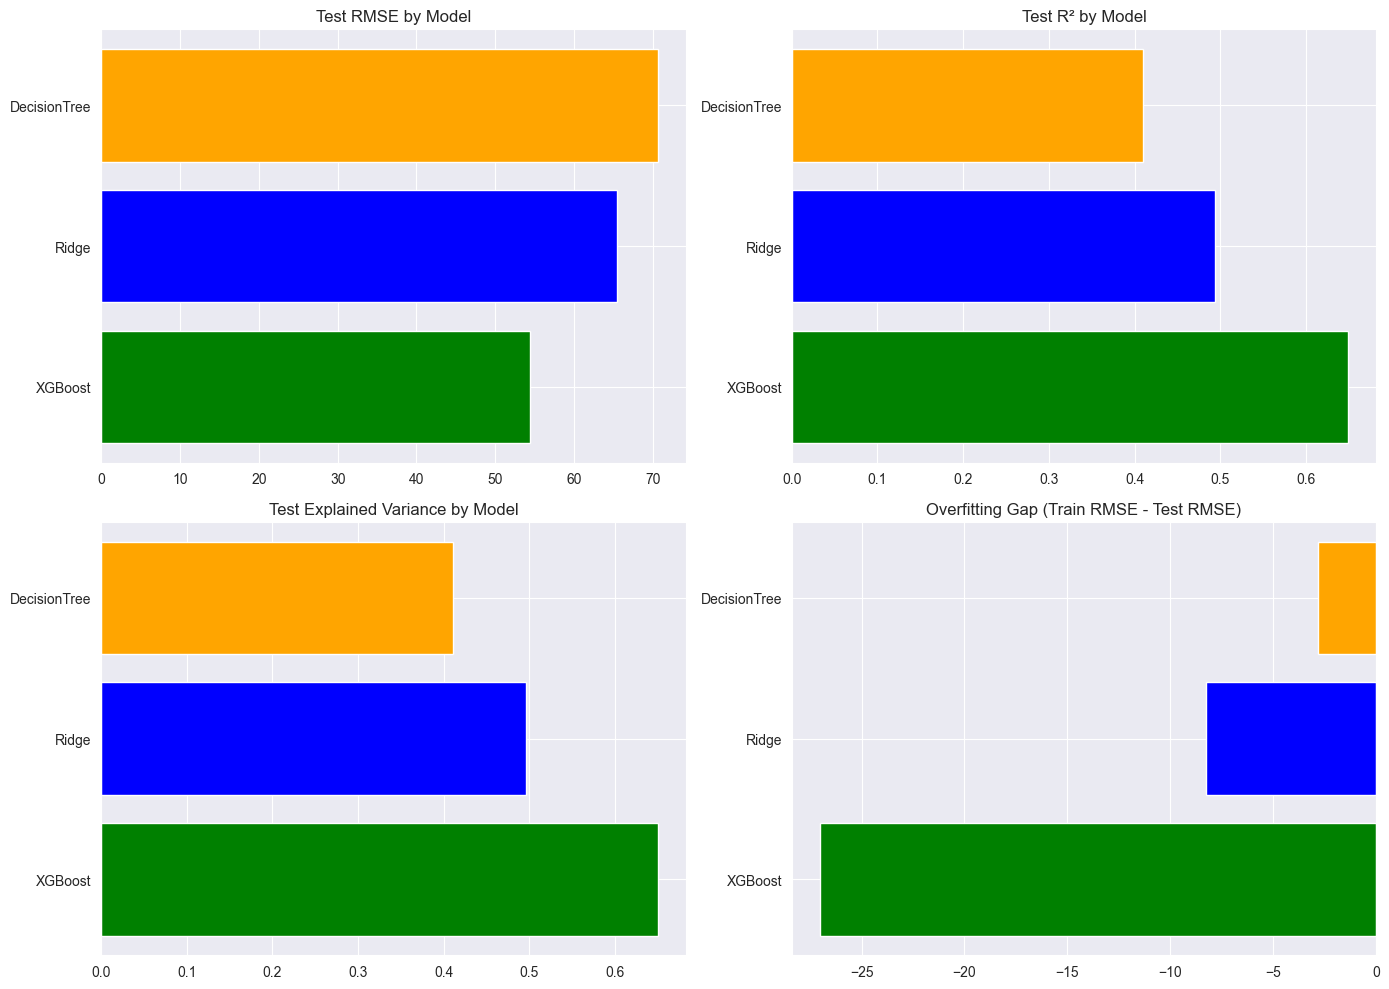

In [43]:
from sklearn.metrics import explained_variance_score

summary_data = []

for model_name, model_info in best_models.items():
    model = model_info['model']
    features = model_info['features']
    X_train_sel = features['X_train']
    X_test_sel = features['X_test']


    y_train_pred = model.predict(X_train_sel)
    y_test_pred = model.predict(X_test_sel)


    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_ev = explained_variance_score(y_train, y_train_pred)
    test_ev = explained_variance_score(y_test, y_test_pred)

    overfitting_gap = train_rmse - test_rmse

    summary_data.append({
        'Model': model_name,
        'Features': features['n_features'],
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_ExplainedVar': train_ev,
        'Test_ExplainedVar': test_ev,
        'Overfitting_Gap': overfitting_gap
    })

final_summary_df = pd.DataFrame(summary_data)

final_summary_df = final_summary_df.sort_values(by='Test_RMSE')

print("\n Model Comparison (by Test RMSE):")
print(final_summary_df.round(4).to_string(index=False))



color_map = {
    'Ridge': 'blue',
    'DecisionTree': 'orange',
    'XGBoost': 'green'
}

final_summary_df['Color'] = final_summary_df['Model'].map(color_map)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot: Test RMSE
axes[0, 0].barh(
    final_summary_df['Model'],
    final_summary_df['Test_RMSE'],
    color=final_summary_df['Color']
)
axes[0, 0].set_title('Test RMSE by Model')

# Plot: Test R2
axes[0, 1].barh(
    final_summary_df['Model'],
    final_summary_df['Test_R2'],
    color=final_summary_df['Color']
)
axes[0, 1].set_title('Test R2 by Model')

# Plot: Test Explained Variance
axes[1, 0].barh(
    final_summary_df['Model'],
    final_summary_df['Test_ExplainedVar'],
    color=final_summary_df['Color']
)
axes[1, 0].set_title('Test Explained Variance by Model')

# Plot: Overfitting Gap
axes[1, 1].barh(
    final_summary_df['Model'],
    final_summary_df['Overfitting_Gap'],
    color=final_summary_df['Color']
)
axes[1, 1].set_title('Overfitting Gap (Train RMSE - Test RMSE)')

plt.tight_layout()
plt.show()


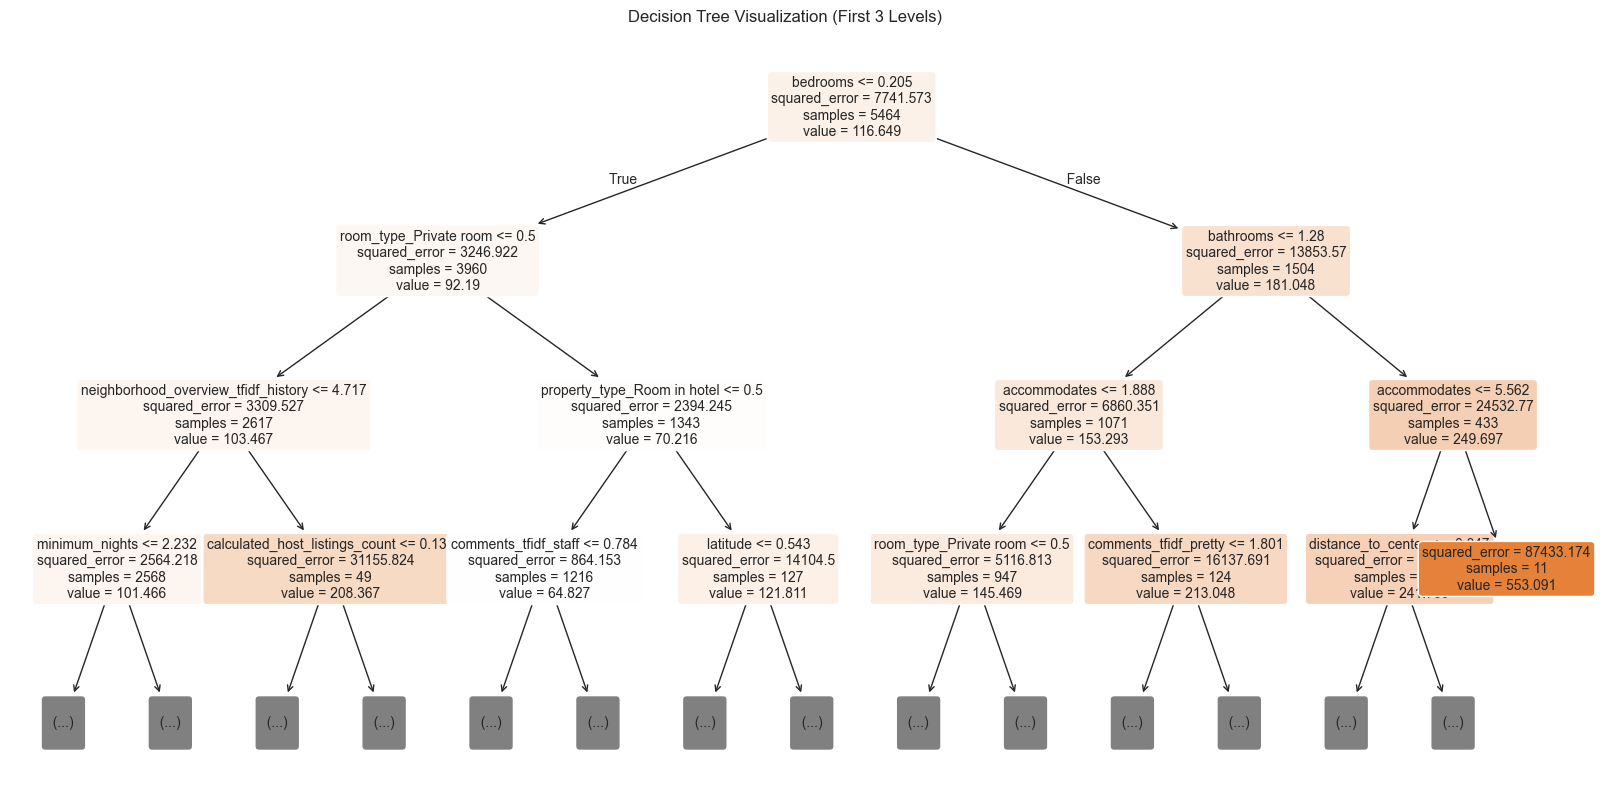

In [47]:
from sklearn.tree import plot_tree

dt_model = best_models['DecisionTree']['model']
dt_features = best_models['DecisionTree']['features']['X_train'].columns

plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=dt_features,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10
)
plt.title('Decision Tree Visualization (First 3 Levels)')
plt.show()
